In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

# 1. 차량 이미지 파일 읽기

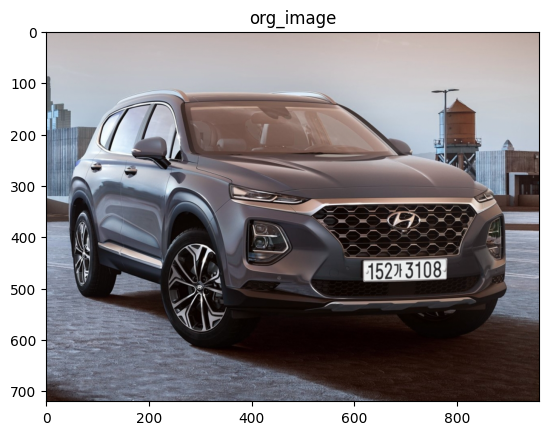

In [2]:
image_path = "./data/car_license_plate.png"

image = cv2.imread(image_path)

imgae = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('org_image')
plt.show()

# 2. 차량 이미지 Grayscale  변환

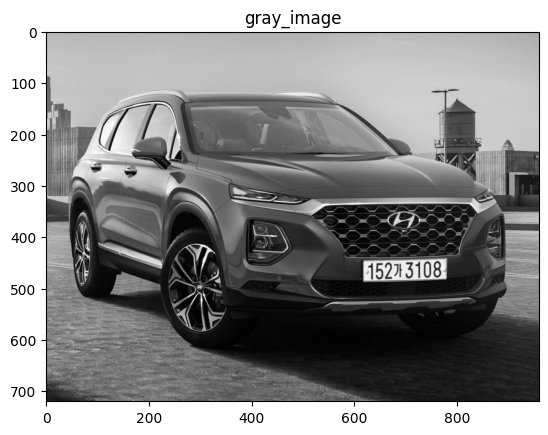

In [3]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, 'gray')
plt.title('gray_image')
plt.show()

# 3. 차량 이미지 Maximize contrast

- 선명도 높이기 : 어두운 부분과 밝은 부분의 차이 높이기

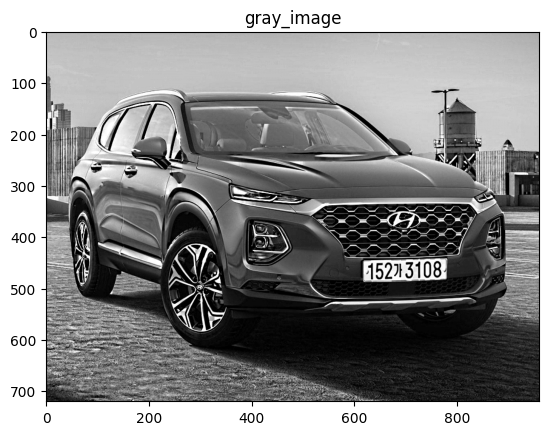

In [4]:
#모폴로지 연산
#9x9 크기의 직사각형 형태의 구조요소를 생성하여 structuringElement 변수에 할당
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))

#TOPHAT -> 밝기 깂이 크게 변화하는 영역 강조
imgTopHat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, structuringElement)
#BLACKHAT -> 어두운 부분을 강조
imgBlackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, structuringElement)

#cv2.add -> 두영상의 같은 위치에 존재하는 픽셀 값을 더하여 결과 영상의 픽셀 값으로 설정
imgGrayScalePlusTopHat = cv2.add(gray_image, imgTopHat)

"""뺄셈 연산 =cv2.subtrack"""
gray = cv2.subtract(imgGrayScalePlusTopHat, imgBlackHat)

plt.imshow(gray, 'gray')
plt.title('gray_image')
plt.show()



# 4. 차량 이미지 이진화 (Adaptive Threshoding)

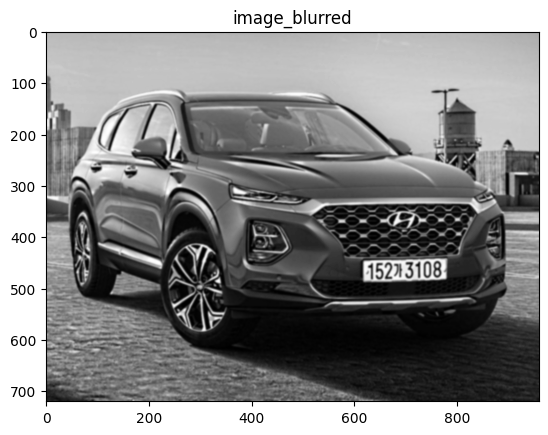

<function matplotlib.pyplot.show(close=None, block=None)>

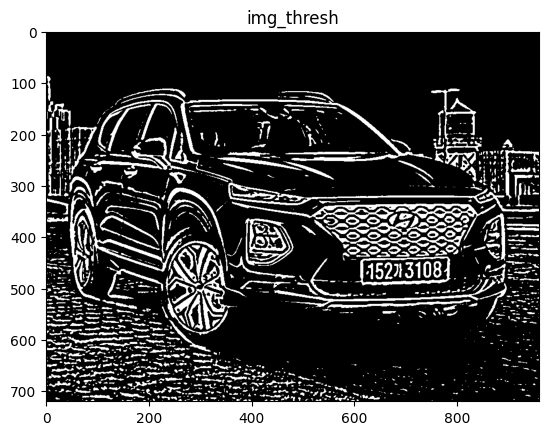

In [5]:
img_blurred = cv2.GaussianBlur(gray, ksize=(7,7), sigmaX=0)

plt.imshow(img_blurred, 'gray')
plt.title('image_blurred')
plt.show()

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

plt.imshow(img_thresh, 'gray')
plt.title('img_thresh')
plt.show

# 5. 차량 이미지 Find Contours (이미지에서 객체의 외각선 검출)

"Find Contour"는 영상처리에서 사용되는 기술로, 이미지에서 객체의 외곽선을 검출하는 과정
을 말합니다. 

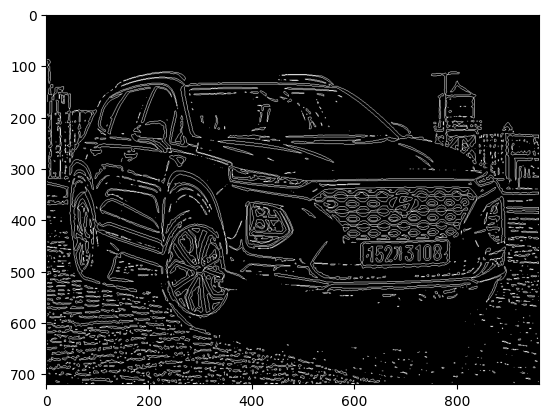

In [6]:
contours, hierarchy = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method= cv2.CHAIN_APPROX_NONE
)

height, width, channel = image.shape
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# contours 그리기
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.imshow(temp_result, 'gray')
plt.show()

# 6. 차량 이미지 전처리 (바운딩 박스 표시)

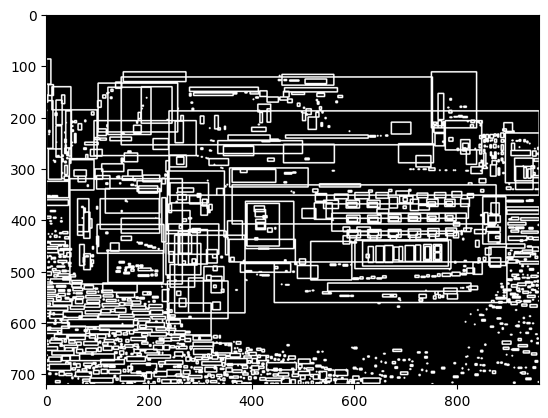

In [7]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours :
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)

    #insert to dict
    contours_dict.append({
        'contour' : contour,
        'x' :x,
        'y' : y,
        "w" : w,
        'h' : h,
        'cx' : x + (w/2),
        'cy' : y + (h/2)
    })

plt.imshow(temp_result, 'gray')
plt.show()


# 7. 차량 이미지 Select Candidates by Char Size 변환

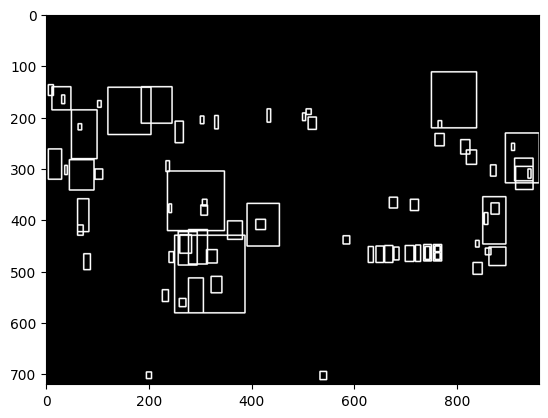

In [8]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2 ,8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w']* d['h']
    ratio = d['w']/d['h']

    if area > MIN_AREA\
    and d['w'] > MIN_WIDTH and d['h']> MIN_HEIGHT\
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

# visualixe possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+ d['h']), color=(255,255,255), thickness=2)

plt.imshow(temp_result, 'gray')
plt.show()

# 8. 차량 번호판 이미지 Select Candidates by Arrangement of contours 변환

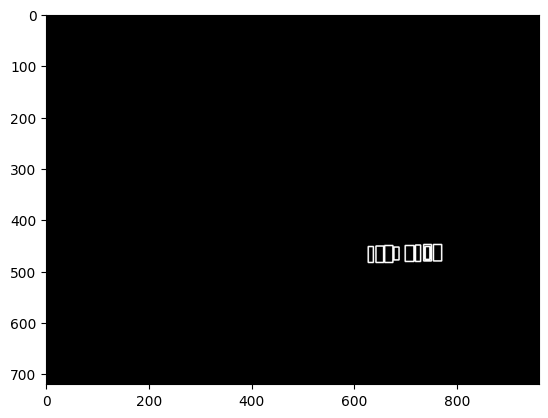

In [9]:
MAX_DIAG_MULTIPLAYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF= 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
        matched_result_idx = []

        for d1 in contour_list:
                matched_contours_idx = []
                for d2 in contour_list : 
                        if d1['idx'] == d2['idx']:
                                continue

                        dx = abs(d1['cx'] -d2['cx'])
                        dy = abs(d1['cy'] - d2['cy'])

                        diagonal_length1 = np.sqrt(d1['w'] ** 2 +d1['h']**2)

                        distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
                        if dx == 0:
                                angle_diff = 90
                        else : 
                                angle_diff = np.degrees(np.arctan(dy/dx))
                        area_diff = abs(d1['w']* d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
                        width_diff = abs(d1['w'] - d2['w']) / d1['w']
                        height_diff = abs(d1['h'] - d2['h']) / d1['h']

                        if distance < diagonal_length1 * MAX_DIAG_MULTIPLAYER \
                        and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
                        and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                                matched_contours_idx.append(d2['idx'])

                # append this contour
                matched_contours_idx.append(d1['idx'])
                if len(matched_contours_idx) < MIN_N_MATCHED:
                        continue

                matched_result_idx.append(matched_contours_idx)

                unmatched_contour_idx = []
                for d4 in contour_list:
                        if d4['idx'] not in matched_contours_idx:
                                unmatched_contour_idx.append(d4['idx'])

                unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

                #recursive
                recursive_contour_list = find_chars(unmatched_contour)

                for idx in recursive_contour_list:
                        matched_result_idx.append(idx)
                break

        return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result=[]
for idx_list in result_idx :
        matched_result.append(np.take(possible_contours, idx_list))

#visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
        for d in r :
                cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2 )

plt.imshow(temp_result, 'gray')
plt.show()




# 9. 차량 번호판 이미지를 회전시키는 작업

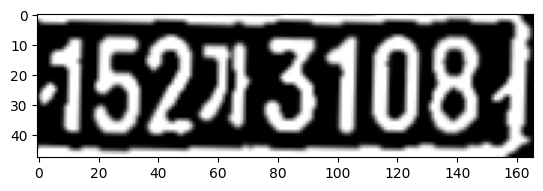

In [10]:
PLATE_WIDTH_PADDING =1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RAITO = 10

plate_image = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars =sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars : 
        sum_height +=d['h']

        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )
        angle = np.degrees(np.arcsin(triangle_height/ triangle_hypotenus))
        rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle= angle, scale=1.0)
        img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

        img_cropped = cv2.getRectSubPix(
            img_rotated,
            patchSize=(int(plate_width), int(plate_height)), center=(int(plate_cx), int(plate_cy))
        )

        plate_image.append(img_cropped)
        plate_infos.append({
            'x': int(plate_cx - plate_width /2),
            'y': int(plate_cy - plate_height /2),
            'w': int(plate_width),
            'h': int(plate_height)
        })

plt.imshow(img_cropped, 'gray')
plt.show()

# 10.차량 번호판 Another Thresholding to Find Chars

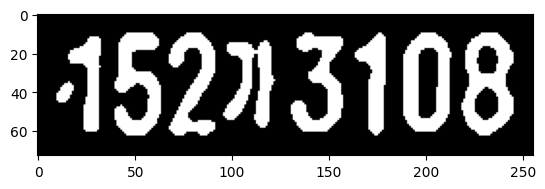

In [19]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_image):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # contours 찾기 (method 인자 추가)
    contours, hierarchy = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        area = w * h
        ratio = w / h

        if area > MIN_AREA and w > MIN_WIDTH and h > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h

    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

plt.imshow(img_result, "gray")
plt.show()


# 11. 차량 번호판 바운딩 박스 표시 결과 이미지

{'x': 622, 'y': 441, 'w': 166, 'h': 48}


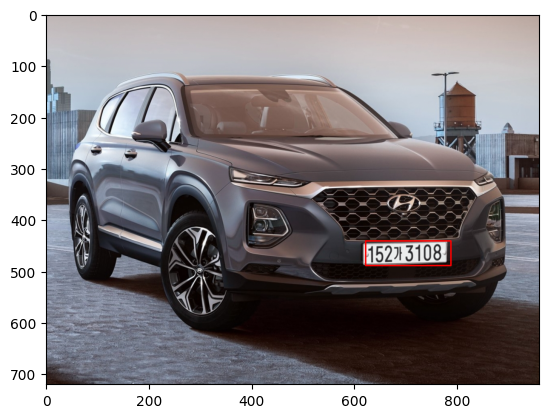

In [21]:
info = plate_infos[longest_idx]
img_out = image.copy()

print(info)

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x'] + info['w'], info['y']+info['h']),
                            color=(255,0,0), thickness=2)

plt.imshow(img_out)
plt.show()